# Combining Predictors
- Combine classifiers by averaging or voting
- Improves accuracy
- Boosting, Bagging, and Random Forests combine similar classifiers
- Model stacking or Model ensembling, combine different classifiers

## Example
- Using Wage datset

In [1]:
library(ISLR)
library(ggplot2)
library(caret)

data(Wage)

# Remove Variable with no Variability
nzv <- nearZeroVar(Wage, saveMetrics = TRUE)
nzv

Loading required package: lattice


,freqRatio,percentUnique,zeroVar,nzv
year,1.057732,0.23333333,FALSE,FALSE
age,1.153061,2.03333333,FALSE,FALSE
maritl,3.200617,0.16666667,FALSE,FALSE
race,8.464164,0.13333333,FALSE,FALSE
education,1.417518,0.16666667,FALSE,FALSE
region,0.000000,0.03333333,TRUE,TRUE
jobclass,1.060440,0.06666667,FALSE,FALSE
health,2.496503,0.06666667,FALSE,FALSE
health_ins,2.271538,0.06666667,FALSE,FALSE
logwage,1.052632,16.93333333,FALSE,FALSE


In [2]:
# Remove region and  logwage
Wage <- subset(Wage, select = -c(region, logwage))

In [3]:
# Create Building dataset and Validation dataset
inBuild <- createDataPartition(y = Wage$wage, p = 0.7, list = FALSE)

validation <- Wage[-inBuild,]
buildData <- Wage[inBuild,]

inTrain <- createDataPartition(y = buildData$wage, p = 0.7, list = FALSE)
training <- buildData[inTrain,]
testing <- buildData[-inTrain,]

In [4]:
dim(training)

[1] 1474    9

In [5]:
dim(testing)

[1] 628   9

In [6]:
dim(validation)

[1] 898   9

## Use Training set to build Models
- Build 2 Models: regression and boosting (gbm)
- Can use cross validation 

In [7]:
# Model 1: Regression
model1 <- train(wage ~ ., method = "glm", data = training)

In [8]:
model1

Generalized Linear Model 

1474 samples
   8 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1474, 1474, 1474, 1474, 1474, 1474, ... 
Resampling results:

  RMSE      Rsquared 
  33.88225  0.3496871


In [9]:
# Model 2: gbm
model2 <- train(wage ~ ., method = "gbm", data = training, verbose = FALSE)

Loading required package: gbm
Loading required package: survival

Attaching package: ‘survival’

The following object is masked from ‘package:caret’:

    cluster

Loading required package: splines
Loading required package: parallel
Loaded gbm 2.1.3
Loading required package: plyr


In [10]:
model2$finalModel

A gradient boosted model with gaussian loss function.
50 iterations were performed.
There were 16 predictors of which 12 had non-zero influence.

## Predict and Plot the 2 Model Prediction vs each other
- Good but not perfect fit

In [11]:
prediction1 <- predict(model1, newdata = testing)
prediction2 <- predict(model2, newdata = testing)

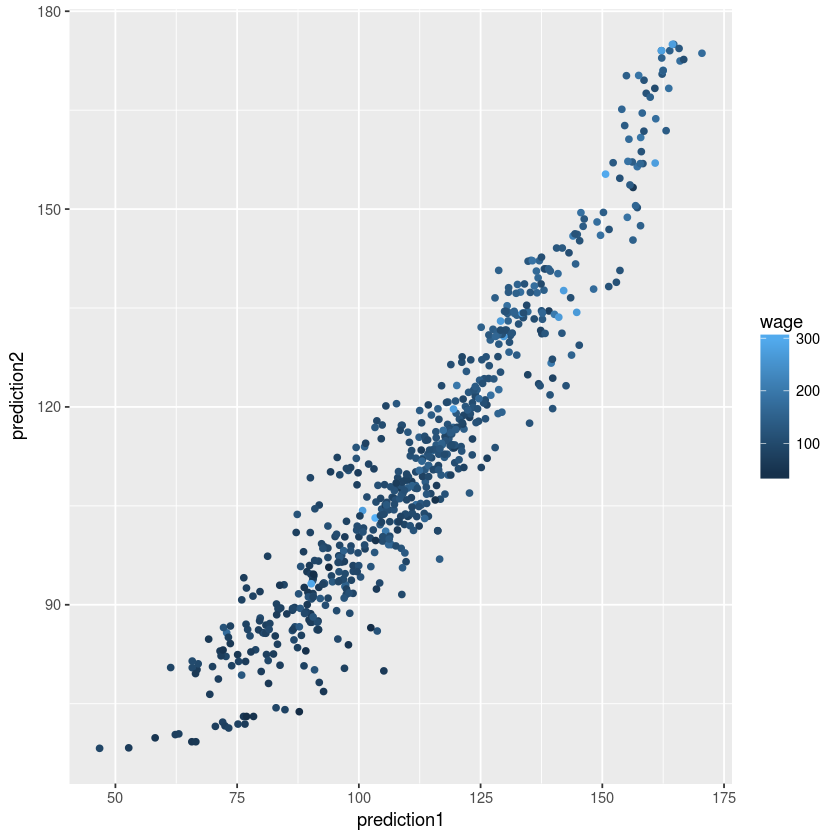

In [12]:
qplot(prediction1, prediction2, color = wage, data = testing)

## Fit a New Model that combines the predictors
- Using a new method: Random Forests (rf)

In [14]:
predictionDF <- data.frame(prediction1, prediction2, wage = testing$wage)
head(predictionDF)

,prediction1,prediction2,wage
86582,91.86816,78.22497,70.47602
376662,140.61792,144.09257,127.11574
160191,86.36127,89.17118,82.67964
230312,143.98410,145.91810,212.84235
158226,105.51186,101.15631,200.54326
86064,97.11988,100.29628,65.11085


In [48]:
combinedModel <- train(wage ~ ., method = "gam", data = predictionDF)

Loading required package: mgcv
Loading required package: nlme
This is mgcv 1.8-17. For overview type 'help("mgcv-package")'.


## Use the New Combined Model to predict on the Validation Set

In [49]:
prediction1 <- predict(model1, newdata = validation)
prediction2 <- predict(model2, newdata = validation)

In [50]:
validationPredDF <- data.frame(prediction1, prediction2)
head(validationPredDF)

,prediction1,prediction2
161300,111.72176,108.66417
155159,125.52124,133.46409
450601,125.22341,122.28395
302778,105.39996,104.25419
305706,91.71282,89.92786
153561,126.70771,130.91539


In [51]:
combinedPred <- predict(combinedModel, newdata = validationPredDF)

In [52]:
head(combinedPred)

161300    155159    450601    302778    305706    153561 
109.40235 133.15327 124.17079 103.97790  88.56994 131.43879

## Testing Errors

In [53]:
sqrt(sum(prediction1 - validation$wage)^2)

[1] 23.09862

In [54]:
sqrt(sum(prediction2 - validation$wage)^2)

[1] 1.432078

In [55]:
sqrt(sum(combinedPred - validation$wage)^2)

[1] 220.5687